# Likelihood Analysis with fermipy

The python likelihood tools are a very powerful set of analysis tools that expand upon the command line tools provided with the Fermi Science Tools package. Not only can you perform all of the same likelihood analysis with the python tools that you can with the standard command line tools but you can directly access all of the model parameters. You can more easily script a standard analysis. There are also a few things built into the python tools that are not available from the command line like the calculation of upper limits.

There are many user contributed packages built upon the python backbone of the Science Tools and this thread will highlight the use of the fermipy package.

This sample analysis is based on the Draco dwarf galaxy analysis performed by the LAT team and described in Ackermann et al. (2015), and closely follows the Likelihood Analysis with Python thread. This tutorial assumes you have the most recent ScienceTools installed and fermipy installed on top of it. For instructions on installing fermipy and the Fermi ScienceTools you should consult the fermipy Installation Instructions. We will also make significant use of python, so you might want to familiarize yourself with python including matplotlib and other libraries (there's a beginner's guide at http://wiki.python.org/moin/BeginnersGuide).

# Get the Data

For this thread the original data were extracted from the [LAT data server](https://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi) with the following selections (the ones used in the [6-year LAT Dwarf Analysis](https://arxiv.org/abs/1503.02641)).

    10x10 degree ROI
    Start Time (MET) = 239557417 seconds
    Stop Time (MET) = 428903014 seconds
    Minimum Energy = 500 MeV
    Maximum Energy = 500000 MeV
    zmax = 100 deg
    P8R2_SOURCE_V6 (evclass=128)

The P8 dSph paper used a multi-component analysis that used the four PSF event types in a joint likelihood. In this example we will perform a single component analysis using all SOURCE-class events (evtype=3).


Once you exectute the query you can download the data and put it in your data directory. You'll then need to make a file list with the names of your input event files. You can either just make one with a text editor or do the following from the command line.

In [56]:
ls ./data/*PH* > Draco.lst

Alternatively you can run with the following tarball which already contains the downloaded files as well as all of the ancillary files that will be generated for the analysis.


# Make a config file

fermipy bases its analysis on a configuration file (in yaml format). We're just going to use a really simple config file for a standard analysis. There are many many more options which you can use or you can modify these options after the fact within the analysis chain.

Make a config file named 'config.yaml' like the following. For more details on the config file see config.html. You will probably need to customize this a bit since your files might not be in the same place or named the same. The galactic and isotropic diffuse will need to be located on your system (they are included in the science tools or can be downloaded from the FSSC). In the following example we set the path to these files with the environment variable FERMI_DIFFUSE_DIR. If FERMI_DIFFUSE_DIR is not defined fermipy will look for the location of these files within the FSSC STs distribution.

    data:
      evfile : Draco.lst
      scfile : ./data/SCfile.fits
      ltcube : Dracolt.fits #Erase this line if you want to generate a new live time cube (it can take a couple hours)

    binning:
      roiwidth   : 10.0  #Size of the region of interest (ROI)
      binsz      : 0.1
      binsperdec : 8     #Number of bins per decade of energy

    selection :
      emin : 500       #Minimum energy
      emax : 500000    #Maximum energy
      zmax    : 100    #Zenith cut
      evclass : 128
      evtype  : 3
      tmin    : 239557417 # Seconds. In terms of mission elapsed time (MET)
      tmax    : 428903014 # 6 years
      ra: 260.05167
      dec: 57.91528

    gtlike:
      edisp : True
      irfs : 'P8R2_SOURCE_V6'
      edisp_disable : ['isodiff','galdiff']

    model:
      # Include catalog sources within a box of width roisrc.
      src_roiwidth : 15.0
      
      galdiff  : '$FERMI_DIFFUSE_DIR/gll_iem_v06.fits'
  isodiff  : '$FERMI_DIFFUSE_DIR/iso_P8R2_SOURCE_V6_v06.txt'
      # List of catalogs to be used in the model.
      catalogs : ['3FGL']
      sources :
        - { name : 'draco', ra : 260.05167, dec : 57.91528, 
             SpectrumType : 'PowerLaw', Index : 2.0, Prefactor : { 'value' : 0.0, 'scale' : 1e-13 } }




# Start the analysis

To get started we will first instantiate a GTAnalysis instance using the config file in the draco directory and the run the setup() method. This will prepare all the ancillary files and create the pylikelihood instance for binned analysis. Note that in this example these files have already been generated so the routines that would normally be executed to create these files will be skipped.

### Load up some useful modules

In [57]:
%matplotlib inline
import os
import numpy as np
from fermipy.plotting import ROIPlotter, SEDPlotter
import matplotlib.pyplot as plt
import matplotlib

### Import the GTAnalysis module from fermipy

You start by importing the module and then creating an instance of the analysis object from our config file. When instantiating the analysis object we can override any options defined in the configuration file by passing keyword arguments to the object constructor. Here we explicitly set the verbosity parameter to 3 (INFO) which supresses DEBUG output. When we create the object, it spits out a bunch of information about all of the parameters that were used. You can see there are many more options than the ones we chose.

In [58]:
from fermipy.gtanalysis import GTAnalysis
gta = GTAnalysis('config.yaml',logging={'verbosity': 3})
matplotlib.interactive(True)
gta.setup()
gta.write_roi('fit0')

2018-07-10 12:17:24 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version 0.16.0 
ScienceTools version 
2018-07-10 12:17:25 INFO    GTAnalysis.setup(): Running setup.
2018-07-10 12:17:25 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2018-07-10 12:17:25 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2018-07-10 12:17:25 INFO    GTBinnedAnalysis.setup(): Using external LT cube.
2018-07-10 12:17:25 INFO    GTBinnedAnalysis._create_expcube(): Skipping gtexpcube.
2018-07-10 12:17:25 INFO    GTBinnedAnalysis._create_srcmaps(): Skipping gtsrcmaps.
2018-07-10 12:17:25 INFO    GTBinnedAnalysis.setup(): Finished setup for component 00
2018-07-10 12:17:25 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 00.
2018-07-10 12:17:36 INFO    GTAnalysis.setup(): Initializing source properties
2018-07-10 12:17:36 INFO    GTAnalysis.setup(): Finished setup

Before proceeding with the analysis we'll have a quick look at the files that are produced by the setup function.

In [59]:
ls *fits

3fgl_j1725.3+5853_sed.fits
bexpmap_00.fits
bexpmap_roi_00.fits
ccube_00.fits
ccube.fits
Dracolt.fits
draco_newsrcs_pointsource_powerlaw_2.00_tsmap.fits
draco_postfit_pointsource_powerlaw_2.00_residmap.fits
draco_postfit_pointsource_powerlaw_2.00_tsmap.fits
draco_prefit_pointsource_powerlaw_2.00_residmap.fits
draco_sed.fits
fit0.fits
fit1.fits
fit_sed.fits
ft1_00.fits
sourcefind_00_pointsource_powerlaw_2.00_tsmap.fits
sourcefind_01_pointsource_powerlaw_2.00_tsmap.fits
srcmap_00.fits




Here is a brief explanation of the contents of each file and its role in the analysis:

   * ft1_00.fits: Event list. This is generated by running gtselect and gtmktime on our input file list.
   * bexpmap_00.fits: All-sky binned exposure map. This map is interpolated to create an exposure model when generating the srcmap file.
   * bexpmap_roi_00.fits: Binned exposure map for the ROI. This file is only provided for visualization purposes in order to have an exposure map with the same binning as the data and model maps.
   * ccube_00.fits: Counts cube for the ROI.
   * ltcube_00.fits: Livetime cube. This contains a map of the livetime for this observation over the whole sky as a function of incidence angle.
   * srcmap_00.fits: Source map cube. This file contains maps for each of the components in the ROI after convolution with exposure and the PSF. Note that energy dispersion is applied at run-time.

Note that all of the files have a numerical suffix '00'. This is the analysis component index. In a multi-component analysis there would be instances of all of the above files for each analysis component. The files with no component index are co-added maps that are provided for visualization purposes.

To see example of one of these files we can open and plot the counts cube file. This is a 3D cube that contains the distribution of events as a function of energy and two spatial coordinates. In the example below we sum over the energy dimension of the cube to make a 2-D sky image.


Filename: ccube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (100, 100, 24)   float64   


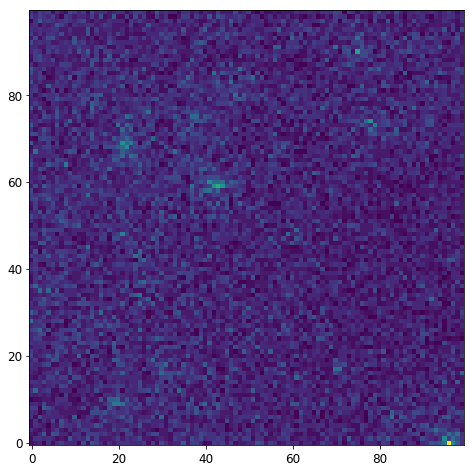

In [60]:
import astropy.io.fits as pyfits

h = pyfits.open('ccube.fits')
h.info()
counts = h[0].data
counts.shape
plt.figure(figsize=(16,8))
plt.imshow(np.sum(counts,axis=0),interpolation='nearest',origin='lower')
plt.savefig('draco_cmap.png')

## Print the ROI model

We can print the ROI object to see a list of sources in the model along with their distance from the ROI center (offset), TS, and number of predicted counts (Npred). Since we haven't yet fit any sources, the ts of all sources will initially be assigned as nan.

In [61]:
gta.print_roi()
print(gta.roi['draco'])

2018-07-10 12:17:38 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
draco               PointSource    PowerLaw          0.000       nan         0.0
3FGL J1725.3+5853   PointSource    PowerLaw          1.181       nan       257.7
3FGL J1732.7+5914   PointSource    PowerLaw          2.107       nan       114.0
3FGL J1707.8+5626   PointSource    PowerLaw          2.231       nan       142.9
3FGL J1729.0+6049   PointSource    PowerLaw          3.121       nan       173.8
3FGL J1722.7+6104   PointSource    PowerLaw          3.184       nan       188.8
3FGL J1742.2+5947   PointSource    PowerLaw          3.416       nan       275.4
3FGL J1656.9+6008   PointSource    PowerLaw          3.725       nan       259.6
3FGL J1731.9+5428   PointSource    PowerLaw          3.801       nan       191.5
3FGL J1658.3+6149   PointSource    PowerLaw          4.7

Name           : draco
Associations   : ['draco']
RA/DEC         :    260.052/    57.915
GLON/GLAT      :     86.368/    34.722
TS             : nan
Npred          : 0.00
Flux           :         0 +/-      nan
EnergyFlux     :         0 +/-      nan
SpatialModel   : PointSource
SpectrumType   : PowerLaw
Spectral Parameters
Prefactor      :          0 +/-          0
Index          :         -2 +/-        nan
Scale          :       1000 +/-        nan


We can assess the quality of our pre-fit model by running the residmap method. This will generate four maps


2018-07-10 12:17:38 INFO    GTAnalysis.residmap(): Generating residual maps
2018-07-10 12:17:38 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2018-07-10 12:17:43 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2018-07-10 12:17:51 INFO    GTAnalysis.residmap(): Finished residual maps
2018-07-10 12:17:51 INFO    GTAnalysis.residmap(): Execution time: 12.54 s


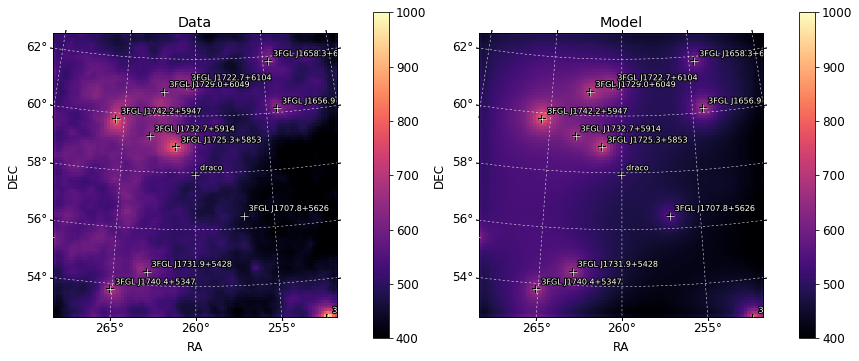

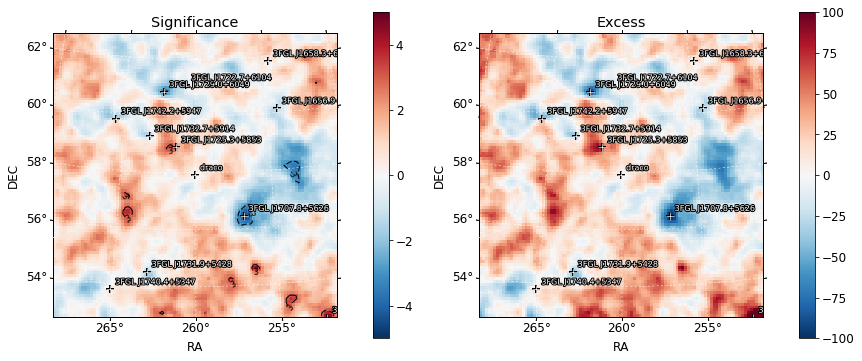

In [62]:
resid = gta.residmap('draco_prefit',model={'SpatialModel' : 'PointSource', 'Index' : 2.0})
fig = plt.figure(figsize=(14,6))
ROIPlotter(resid['data'],roi=gta.roi).plot(vmin=400,vmax=1000,subplot=121,cmap='magma')
plt.gca().set_title('Data')
ROIPlotter(resid['model'],roi=gta.roi).plot(vmin=400,vmax=1000,subplot=122,cmap='magma')
plt.gca().set_title('Model')

fig = plt.figure(figsize=(14,6))
ROIPlotter(resid['sigma'],roi=gta.roi).plot(vmin=-5,vmax=5,levels=[-5,-3,3,5],subplot=121,cmap='RdBu_r')
plt.gca().set_title('Significance')
ROIPlotter(resid['excess'],roi=gta.roi).plot(vmin=-100,vmax=100,subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess')


Now we will run the optimize method. This method will iteratively optimize the parameters of all components in the ROI in several stages:

* Simultaneously fitting the normalization of the brightest model components containing at least some fraction of the total model counts (default 95%).

* Individually fitting the normalization of all remaining sources if they have Npred above some threshold (default 1).

* Individually fitting the normalization and shape of any component with TS larger than some threshold (default 25).

Running optimize gives us a baseline model that we can use as a starting point for subsequent stages of the analysis. We will also save the results of the analysis with write_roi. By saving the analysis state we can restore the analysis to this point at any time with the load_roi method. (NOTE: This step is computationally intensive and can take up to 5-10 minutes)


In [63]:
gta.optimize()
gta.write_roi('fit1')

2018-07-10 12:17:53 INFO    GTAnalysis.optimize(): Starting
2018-07-10 12:19:19 INFO    GTAnalysis.optimize(): Finished
2018-07-10 12:19:19 INFO    GTAnalysis.optimize(): LogLike: -58614.321223 Delta-LogLike: 60.719942
2018-07-10 12:19:19 INFO    GTAnalysis.optimize(): Execution time: 85.96 s
2018-07-10 12:19:19 INFO    GTBinnedAnalysis.write_xml(): Writing /home/raniere/Documents/Fermi/Dark_matter/fit1_00.xml...
2018-07-10 12:19:19 INFO    GTAnalysis.write_fits(): Writing /home/raniere/Documents/Fermi/Dark_matter/fit1.fits...
2018-07-10 12:19:20 INFO    GTAnalysis.write_roi(): Writing /home/raniere/Documents/Fermi/Dark_matter/fit1.npy...


After running _optimize_ we can rerun print_roi to see a summary of the updated model. All sources that were fit in this step now have ts values and an Npred value the reflects the optimized normalization of that source. Note that model components that were not fit during the optimize step still have ts=nan.

In [64]:
gta.print_roi()

2018-07-10 12:19:20 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
draco               PointSource    PowerLaw          0.000       nan         0.0
3FGL J1725.3+5853   PointSource    PowerLaw          1.181    257.76       341.0
3FGL J1732.7+5914   PointSource    PowerLaw          2.107      4.71        33.2
3FGL J1707.8+5626   PointSource    PowerLaw          2.231      0.19         9.1
3FGL J1729.0+6049   PointSource    PowerLaw          3.121      5.84        59.1
3FGL J1722.7+6104   PointSource    PowerLaw          3.184     39.47       180.9
3FGL J1742.2+5947   PointSource    PowerLaw          3.416    154.81       229.0
3FGL J1656.9+6008   PointSource    PowerLaw          3.725     77.45       206.5
3FGL J1731.9+5428   PointSource    PowerLaw          3.801     22.88       132.7
3FGL J1658.3+6149   PointSource    PowerLaw          4.7

To evaluate the quality of the optimized model we can rerun the residmap method. In the updated residual map that we see that there is no longer a negative residual in the vicinity of J1707.

2018-07-10 12:19:20 INFO    GTAnalysis.residmap(): Generating residual maps
2018-07-10 12:19:20 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2018-07-10 12:19:26 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2018-07-10 12:19:33 INFO    GTAnalysis.residmap(): Finished residual maps
2018-07-10 12:19:33 INFO    GTAnalysis.residmap(): Execution time: 12.84 s


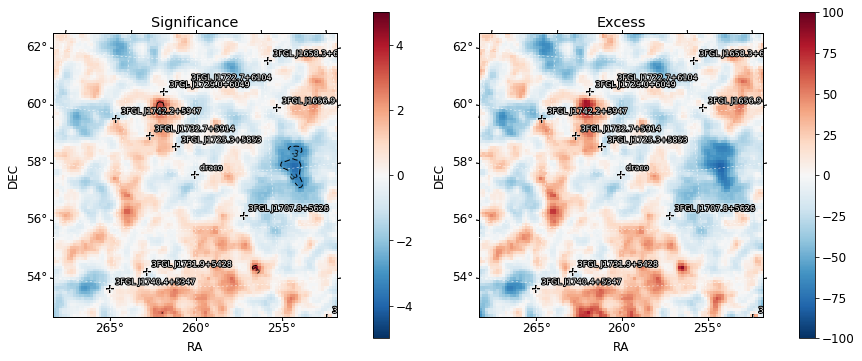

In [65]:
resid = gta.residmap('draco_postfit',model={'SpatialModel' : 'PointSource', 'Index' : 2.0})
fig = plt.figure(figsize=(14,6))
ROIPlotter(resid['sigma'],roi=gta.roi).plot(vmin=-5,vmax=5,levels=[-5,-3,3,5],subplot=121,cmap='RdBu_r')
plt.gca().set_title('Significance')
ROIPlotter(resid['excess'],roi=gta.roi).plot(vmin=-100,vmax=100,subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess')

Another diagnostic for the quality of the ROI model is the TS map. The tsmap method can be used to generate a TS map of the ROI with a given test source model. Here we use the same source model we did for the residual map -- a point source with a power-law index of 2.

In [66]:
tsmap_postfit = gta.tsmap('draco_postfit',model={'SpatialModel' : 'PointSource', 'Index' : 2.0})

2018-07-10 12:19:34 INFO    GTAnalysis.tsmap(): Generating TS map
2018-07-10 12:19:44 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2018-07-10 12:19:56 INFO    GTAnalysis.tsmap(): Finished TS map
2018-07-10 12:19:56 INFO    GTAnalysis.tsmap(): Execution time: 21.51 s


Here we see that the excess in the northeast part of the ROI appears more prominent than in the residual map. This excess is detected as a new point source with TS > 25.

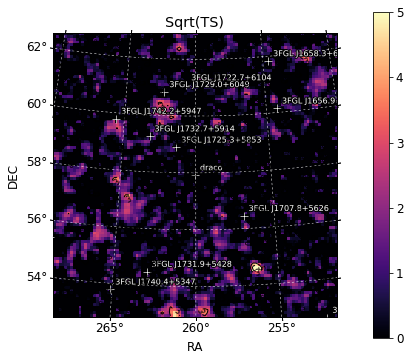

In [67]:
fig = plt.figure(figsize=(14,6))
ROIPlotter(tsmap_postfit['sqrt_ts'],roi=gta.roi).plot(levels=[0,3,5,7],vmin=0,vmax=5,subplot=121,cmap='magma')
plt.gca().set_title('Sqrt(TS)')

We can add this source into the model by running the find_sources method. This method will generate a TS map of the region and add a point-source at the location of each peak with TS > 25.

In [68]:
srcs = gta.find_sources(sqrt_ts_threshold=5.0, min_separation=0.5,multithread=True)

2018-07-10 12:19:57 INFO    GTAnalysis.find_sources(): Starting.
2018-07-10 12:19:57 INFO    GTAnalysis.tsmap(): Generating TS map
2018-07-10 12:20:09 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2018-07-10 12:20:13 INFO    GTAnalysis.tsmap(): Finished TS map
2018-07-10 12:20:13 INFO    GTAnalysis.tsmap(): Execution time: 15.79 s
2018-07-10 12:20:13 INFO    GTAnalysis._build_src_dicts_from_peaks(): Found source
name: PS J1705.4+5435
ts: 47.510980
2018-07-10 12:20:13 INFO    GTAnalysis.add_source(): Adding source PS J1705.4+5435
2018-07-10 12:20:16 INFO    GTAnalysis.free_source(): Fixing parameters for PS J1705.4+5435       : ['Prefactor']
2018-07-10 12:20:16 INFO    GTAnalysis._find_sources_iterate(): Performing spectral fit for PS J1705.4+5435.
2018-07-10 12:20:16 INFO    GTAnalysis.free_source(): Freeing parameters for PS J1705.4+5435       : ['Prefactor', 'Index']
2018-07-10 12:20:16 INFO    GTAnalysis.fit(): Starting fit.
2018-07-10 12:20:20 INFO    GTAnalysis.fit()

From the log we can see that a new source PS J1705.4+5435 was found with TS~50. Rerunning the tsmap method we can see that this source is located at the peak of the TS Map that was previously present in the northeast corner of the ROI.

2018-07-10 12:20:36 INFO    GTAnalysis.tsmap(): Generating TS map
2018-07-10 12:20:48 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2018-07-10 12:20:59 INFO    GTAnalysis.tsmap(): Finished TS map
2018-07-10 12:20:59 INFO    GTAnalysis.tsmap(): Execution time: 22.95 s


Name           : PS J1705.4+5435
Associations   : ['PS J1705.4+5435']
RA/DEC         :    256.362/    54.592
GLON/GLAT      :     82.450/    36.992
TS             : 48.95
Npred          : 75.89
Flux           : 3.108e-10 +/- 8.76e-11
EnergyFlux     : 1.212e-06 +/- 4.29e-07
SpatialModel   : PointSource
SpectrumType   : PowerLaw
Spectral Parameters
Prefactor      :  1.531e-13 +/-  4.901e-14
Index          :     -1.952 +/-     0.1685
Scale          :       1000 +/-        nan


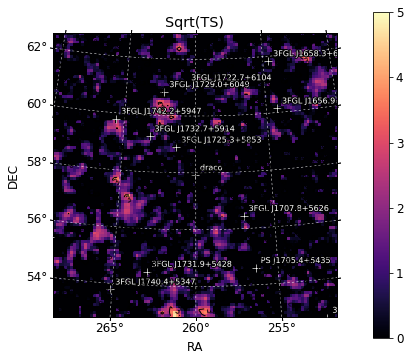

In [69]:
print(gta.roi['PS J1705.4+5435'])
tsmap_newsrcs = gta.tsmap('draco_newsrcs',model={'SpatialModel' : 'PointSource', 'Index' : 2.0})
fig = plt.figure(figsize=(14,6))
ROIPlotter(tsmap_newsrcs['sqrt_ts'],roi=gta.roi).plot(levels=[0,3,5,7],vmin=0,vmax=5,subplot=121,cmap='magma')
plt.gca().set_title('Sqrt(TS)')

### Spectral Analysis

After optimizing the ROI model we are ready to perform our analysis of the source of interest (draco). We will begin by freeing draco along with all other point sources within 3 deg of the ROI center and refitting their normalizations.

In [70]:
gta.free_sources(distance=3.0,pars='norm')
gta.free_sources(distance=3.0,pars='shape',minmax_ts=[100.,None])
fit_results = gta.fit()

2018-07-10 12:21:01 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1725.3+5853     : ['Prefactor']
2018-07-10 12:21:01 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1732.7+5914     : ['Prefactor']
2018-07-10 12:21:01 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1707.8+5626     : ['Prefactor']
2018-07-10 12:21:01 INFO    GTAnalysis.free_source(): Freeing parameters for isodiff               : ['Normalization']
2018-07-10 12:21:01 INFO    GTAnalysis.free_source(): Freeing parameters for galdiff               : ['Prefactor']
2018-07-10 12:21:01 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1725.3+5853     : ['Index']
2018-07-10 12:21:01 INFO    GTAnalysis.free_source(): Freeing parameters for galdiff               : ['Index']
2018-07-10 12:21:01 INFO    GTAnalysis.fit(): Starting fit.
2018-07-10 12:21:22 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2018-07-10 12:21:22 INFO    GTAnalysis.fi

In [71]:
gta.print_roi()
print(gta.roi['draco'])

2018-07-10 12:21:22 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
draco               PointSource    PowerLaw          0.000     -0.00         0.0
3FGL J1725.3+5853   PointSource    PowerLaw          1.181    256.94       345.4
3FGL J1732.7+5914   PointSource    PowerLaw          2.107      4.22        31.0
3FGL J1707.8+5626   PointSource    PowerLaw          2.231      0.09         6.0
3FGL J1729.0+6049   PointSource    PowerLaw          3.121      5.84        59.1
3FGL J1722.7+6104   PointSource    PowerLaw          3.184     39.47       180.9
3FGL J1742.2+5947   PointSource    PowerLaw          3.416    154.81       229.0
3FGL J1656.9+6008   PointSource    PowerLaw          3.725     77.45       206.5
3FGL J1731.9+5428   PointSource    PowerLaw          3.801     22.88       132.7
PS J1705.4+5435     PointSource    PowerLaw          3.9

Name           : draco
Associations   : ['draco']
RA/DEC         :    260.052/    57.915
GLON/GLAT      :     86.368/    34.722
TS             : -0.00
Npred          : 0.00
Flux           : 2.286e-16 +/- 1.77e-13
EnergyFlux     :   7.9e-13 +/- 6.11e-10
SpatialModel   : PointSource
SpectrumType   : PowerLaw
Spectral Parameters
Prefactor      :  1.144e-19 +/-  8.844e-17
Index          :         -2 +/-        nan
Scale          :       1000 +/-        nan


After running the fit completes we can execute the spectral analysis of draco with the sed method. For comparison we will also perform the spectral analysis of a nearby source (3FGL J1725.3+5853).

In [72]:
sed_draco = gta.sed('draco')
sed_j1725 = gta.sed('3FGL J1725.3+5853')
gta.write_roi('fit_sed')

2018-07-10 12:21:22 INFO    GTAnalysis.sed(): Computing SED for draco
2018-07-10 12:21:48 ERROR   GTAnalysis.fit(): MINUIT failed with status code 102 fit quality 2
2018-07-10 12:21:48 INFO    GTAnalysis._make_sed(): Fitting SED
2018-07-10 12:21:48 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J1725.3+5853     : ['Index']
2018-07-10 12:21:48 INFO    GTAnalysis.free_source(): Fixing parameters for galdiff               : ['Index']
2018-07-10 12:22:49 INFO    GTAnalysis.sed(): Finished SED
2018-07-10 12:22:49 INFO    GTAnalysis.sed(): Execution time: 87.03 s
2018-07-10 12:22:49 INFO    GTAnalysis.sed(): Computing SED for 3FGL J1725.3+5853
2018-07-10 12:22:59 INFO    GTAnalysis._make_sed(): Fitting SED
2018-07-10 12:22:59 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J1725.3+5853     : ['Index']
2018-07-10 12:22:59 INFO    GTAnalysis.free_source(): Fixing parameters for galdiff               : ['Index']
2018-07-10 12:23:51 INFO    GTAnalysis.sed(): Finished S

We can visualize the results of the scan with the SEDPlotter class. This class accepts a source object as its argument and creates a visualization of the SED as a sequence of points with errors. Setting showlnl=True overplots the likelihood function in each bin as a color gradient (the so-called castro plot).

(1e-08, 1e-05)

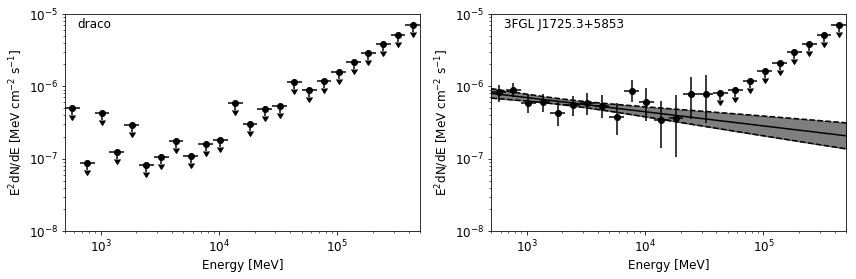

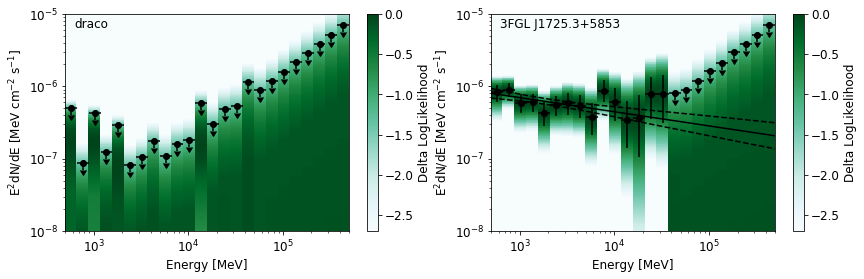

In [73]:
fig = plt.figure(figsize=(14,4))
ylim=[1E-8,1E-5]
fig.add_subplot(121)
SEDPlotter(sed_draco).plot()
plt.gca().set_ylim(ylim)

fig.add_subplot(122)
SEDPlotter(sed_j1725).plot()
plt.gca().set_ylim(ylim)

fig = plt.figure(figsize=(14,4))

fig.add_subplot(121)
SEDPlotter(sed_draco).plot(showlnl=True,ylim=ylim)
plt.gca().set_ylim(ylim)

fig.add_subplot(122)
SEDPlotter(sed_j1725).plot(showlnl=True,ylim=ylim)
plt.gca().set_ylim(ylim)

In [74]:
gta.print_roi()
print(gta.roi['draco'])

2018-07-10 12:23:55 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
draco               PointSource    PowerLaw          0.000     -0.00         0.0
3FGL J1725.3+5853   PointSource    PowerLaw          1.181    256.94       345.4
3FGL J1732.7+5914   PointSource    PowerLaw          2.107      4.22        31.0
3FGL J1707.8+5626   PointSource    PowerLaw          2.231      0.09         6.0
3FGL J1729.0+6049   PointSource    PowerLaw          3.121      5.84        59.1
3FGL J1722.7+6104   PointSource    PowerLaw          3.184     39.47       180.9
3FGL J1742.2+5947   PointSource    PowerLaw          3.416    154.81       229.0
3FGL J1656.9+6008   PointSource    PowerLaw          3.725     77.45       206.5
3FGL J1731.9+5428   PointSource    PowerLaw          3.801     22.88       132.7
PS J1705.4+5435     PointSource    PowerLaw          3.9

Name           : draco
Associations   : ['draco']
RA/DEC         :    260.052/    57.915
GLON/GLAT      :     86.368/    34.722
TS             : -0.00
Npred          : 0.00
Flux           : 2.286e-16 +/- 1.77e-13
EnergyFlux     :   7.9e-13 +/- 6.11e-10
SpatialModel   : PointSource
SpectrumType   : PowerLaw
Spectral Parameters
Prefactor      :  1.144e-19 +/-  8.844e-17
Index          :         -2 +/-        nan
Scale          :       1000 +/-        nan


### Setting DM Upper Limits

Now that we have run a spectral analysis we can use the bin-by-bin likelihoods to gamma-ray flux from DM annihilations in Draco. In the following sample code we demonstrate how to calculate the UL on the DM cross section for a given DM spectral model.

In [75]:
import pyLikelihood

# Load the sed data structure
data = sed_draco

# Instantiate a DM Fit Function for a DM particle spectrum given the following parameters
# Mass = 100 GeV
# Cross-Section: 3 x 10^{-26} cm^{3} s^{-1}
# J-Factor: 10^19 GeV^2 cm^{-5}
# Channel: b-bbar
dmf = pyLikelihood.DMFitFunction()
dmf.readFunction(os.path.expandvars('$FERMIPY_ROOT/data/gammamc_dif.dat'))
dmf.setParam('norm',1E19)
dmf.setParam('sigmav',3E-26)
dmf.setParam('mass',100.0)
dmf.setParam('bratio',1.0)
dmf.setParam('channel0',4)

def integrate_eflux(fn,ebins,nstep=10):
    """Compute energy flux within a sequence of energy bins."""
    
    loge = np.linspace(ebins[0],ebins[-1],100)
    dfde = [fn(pyLikelihood.dArg(10**x)) for x in loge]        
    dfde = np.array(dfde)
    x = ebins
    dx = (x[1:] - x[:-1])

    yedge = x[1:,np.newaxis] + np.linspace(0,1,nstep)[np.newaxis,:]*dx[:,np.newaxis] 
    dy = 10**yedge[:,1:]-10**yedge[:,:-1]
    y = 0.5*(yedge[:,1:]+yedge[:,:-1])
    eflux = np.interp(np.ravel(y),loge,dfde)
    eflux = np.sum(eflux.reshape(y.shape)*10**y*dy,axis=1)

    return eflux

class SEDLike(object):

    def __init__(self,sed):
        self._sed = sed
        self._eflux_scan = sed['norm_scan']*sed['ref_eflux'][:,None]

    def __call__(self,eflux):
        lnl = np.zeros(eflux.shape)
        for i, ectr in enumerate(self._sed['e_ctr']):
            v = np.interp(eflux[i],
                          self._eflux_scan[i],
                          self._sed['dloglike_scan'][i])
            lnl[i] += v
        return np.sum(lnl,axis=0)

ebins = np.log10(np.array(list(data['e_min']) + list([data['e_max'][-1]])))
eflux = integrate_eflux(dmf,ebins)
sigmav = 3.E-26*np.logspace(-3.,1.,101)
eflux = eflux[:,np.newaxis]*np.logspace(-3,1,101)[np.newaxis,:]

slike = SEDLike(data)
lnl = slike(eflux)
lnl -= np.max(lnl)

sigmav_ul = float(np.interp(2.71/2.,-lnl,sigmav))

print 'Sigma-V Upper Limit: ', sigmav_ul,'cm^3 s^-1'

Sigma-V Upper Limit:  3.70256012622e-26 cm^3 s^-1
